## Neural Perturbation Study
Take a recurrent-type neural network, and perturb it with a step input, and watch how it stabilizes over time.

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np



Start with the default pytorch RNN

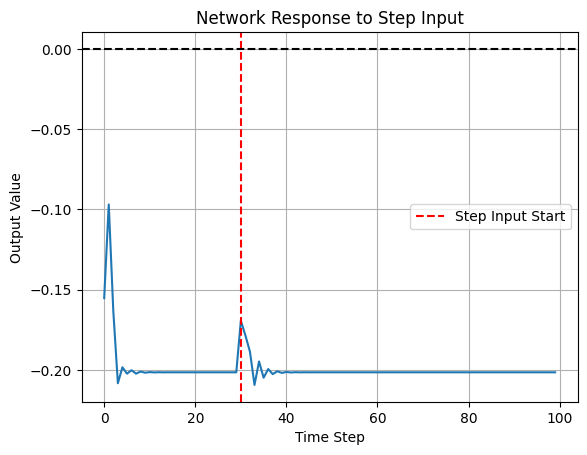

In [3]:
network = torch.nn.RNN(1, 5, 2, nonlinearity='tanh', batch_first=True)
output_weights = nn.Linear(5, 1)  # Learnable output weights matrix (The 'C' Matrix in the state space model)
# output = output_weights(output)  # Apply the output weights to the RNN output

# Create a step input
step_start = 30
step_length = 1

step_input = torch.zeros(1, 100, 1)
step_input[0, step_start:step_start+step_length, 0] = 1.0
# Examine the network's response to the step input
output, hidden = network(step_input)
output = output_weights(output)  # Apply the output weights to the RNN output

# Plot the output over time
plt.plot(output[0, :, :].detach().numpy())
plt.axvline(x=step_start, color='r', linestyle='--', label='Step Input Start')
# plt.axvline(x=step_start+step_length, color='g', linestyle='--', label='Step Input End')
plt.axhline(y=0, color='k', linestyle='--')
plt.legend()
plt.title('Network Response to Step Input')
plt.xlabel('Time Step')
plt.ylabel('Output Value')
plt.grid()
plt.show()


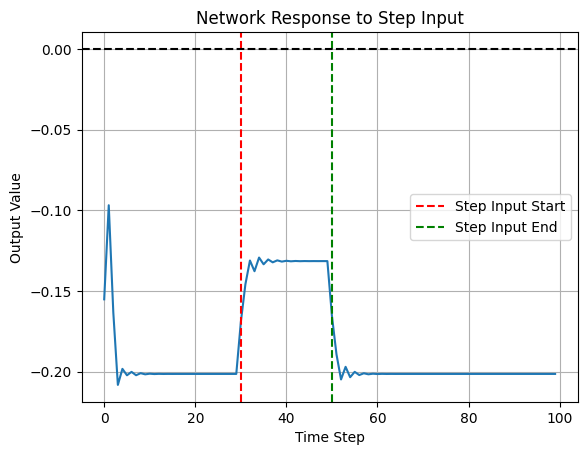

In [4]:
# now let's create a step input with a different length
step_start = 30
step_length = 20
step_input = torch.zeros(1, 100, 1)
step_input[0, step_start:step_start+step_length, 0] = 1.0
# Examine the network's response to the step input
output, hidden = network(step_input)
output = output_weights(output)  # Apply the output weights to the RNN output

# Plot the output over time
plt.plot(output[0, :, :].detach().numpy())
plt.axvline(x=step_start, color='r', linestyle='--', label='Step Input Start')
plt.axvline(x=step_start+step_length, color='g', linestyle='--', label='Step Input End')
plt.axhline(y=0, color='k', linestyle='--')
plt.legend()
plt.title('Network Response to Step Input')
plt.xlabel('Time Step')
plt.ylabel('Output Value')
plt.grid()
plt.show()

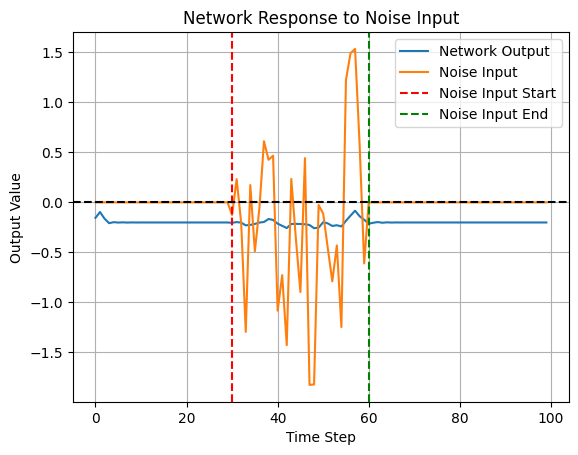

In [5]:
# Now, let's inject a noise signal into the network
# Create a noise input
noise_start = 30
noise_length = 30
noise_input = torch.zeros(1, 100, 1)
noise_input[0, noise_start:noise_start+noise_length, 0] = torch.randn(noise_length)  # Random noise, normally distributed
# Examine the network's response to the noise input
output, hidden = network(noise_input)
output = output_weights(output)  # Apply the output weights to the RNN output

# Plot the output over time
plt.plot(output[0, :, :].detach().numpy(), label="Network Output")
plt.plot(noise_input[0, :, :].detach().numpy(), label="Noise Input")
plt.axvline(x=noise_start, color='r', linestyle='--', label='Noise Input Start')
plt.axvline(x=noise_start+noise_length, color='g', linestyle='--', label='Noise Input End')
plt.axhline(y=0, color='k', linestyle='--')
plt.legend()
plt.grid()
plt.title('Network Response to Noise Input')
plt.xlabel('Time Step')
plt.ylabel('Output Value')
plt.show()

### Now with the Liquid Time Constant network (discrete time, by Shilong)
LTC Network definition

In [12]:
class LTC(nn.Module):
    def __init__(self, input_size, hidden_size, tau=1.0):
        super(LTC, self).__init__()
        self.hidden_size = hidden_size
        self.input_weights = nn.Linear(input_size, hidden_size)
        self.hidden_weights = nn.Linear(hidden_size, hidden_size)
        self.tau = tau

    def forward(self, x, hidden_state):
        input_effect = self.input_weights(x) # x = I(t)
        hidden_effect = self.hidden_weights(hidden_state) # hidden state = X(t)
        combined = input_effect + hidden_effect # combined = A

        time_constant_effect = torch.sigmoid(combined) # time_constant_effect = f( x(t), I(t), t, theta )
        dynamic_time_constants = torch.clamp(self.tau / (1 + self.tau * time_constant_effect), min=0.1, max=1.0) # dynamic_time_constants = toll_sys

        # Calculate dx/dt
        dx_dt = time_constant_effect * combined - hidden_state / dynamic_time_constants # dx_dt = f( x(t), I(t), t, theta) * A - x(t) / toll_sys

        updated_hidden = hidden_state + dx_dt
        return updated_hidden, dx_dt

    def initialize_hidden_state(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

Step Impulse Response

Old shape: (100, 1, 5)
New shape: (100, 5)


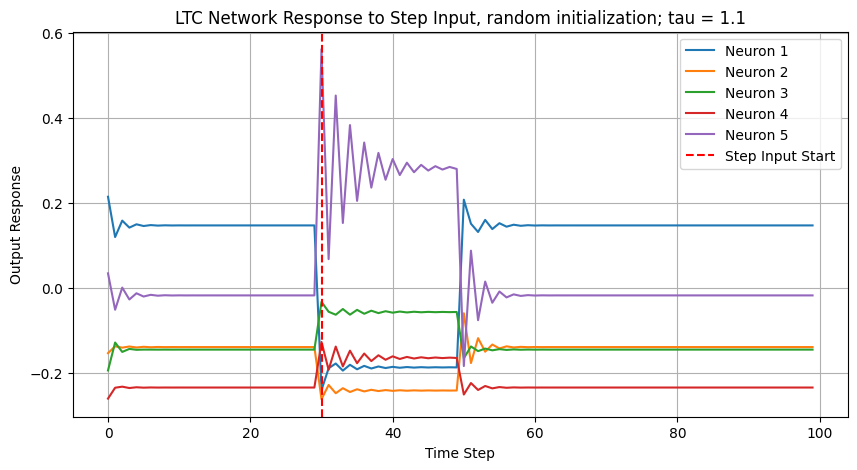

In [13]:
# Perform the same test with the LTC network
tau = 1.1
ltc_network = LTC(input_size=1, hidden_size=5, tau=tau)
ltc_hidden = ltc_network.initialize_hidden_state(batch_size=1)
# ltc_output = np.ndarray()
ltc_output = list()

for t in range(100):
    ltc_hidden, dx_dt = ltc_network(step_input[:, t:t+1, :], ltc_hidden)
    ltc_output.append(ltc_hidden[0].detach().numpy())

# Examine the shape of the output
ltc_output = np.array(ltc_output)
old_shape = ltc_output.shape
ltc_output = np.reshape(ltc_output, (100, 5))
print("Old shape:", old_shape)          # Batch dimension was second I guess.
print("New shape:", ltc_output.shape)   # (100, 5) now, (100, 1, 5) before.

# Plot the output over time for each neuron in the hidden layer of the LTC network
plt.figure(figsize=(10, 5))
for i in range(ltc_network.hidden_size):
    plt.plot(ltc_output[:, i], label=f'Neuron {i+1}')

plt.axvline(x=step_start, color='r', linestyle='--', label='Step Input Start')
plt.legend()
plt.title(f'LTC Network Response to Step Input, random initialization; tau = {tau}')
plt.xlabel("Time Step")
plt.ylabel("Output Response")
plt.grid()
plt.show()

In [14]:
# import numpy as np
import scipy.signal as signal
# import matplotlib.pyplot as plt

def bode_rnn(rnn_model, output_layer, plot=False):
    # Get the state-space matrices from the RNN model
    W = rnn_model.weight_hh_l0.detach().numpy()  # Hidden weights matrix
    U = rnn_model.weight_ih_l0.detach().numpy()  # Input weights matrix

    A = np.eye(W.shape[0]) - (1 - np.tanh(0)**2) * W  # Jacobian (linearized around h=0, assuming tanh activation)
    B = (1 - np.tanh(0)**2) * U  # Linearized input matrix
    C = output_layer.weight.detach().numpy()   # Output weights matrix
    D = np.zeros((1,1))                                          # Feedforward matrix (not used in RNNs)

    # Create the state-space system
    sys = signal.dlti(A, B, C, D)

    # Generate the frequency response
    w, mag, phase = signal.dbode(sys)

    # Optional plot
    if plot:
        plt.figure()
        plt.subplot(2, 1, 1)
        plt.semilogx(w, mag)  # Magnitude (dB)
        plt.ylabel('Gain [dB]')
        plt.subplot(2, 1, 2)
        plt.semilogx(w, phase)  # Phase (degrees)
        plt.ylabel('Phase [deg]')
        plt.xlabel('Frequency [rad/sample]')
        plt.show()
    
    # Return the frequency response data
    return w, mag, phase

c:\Users\Patrick\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\signal\_filter_design.py:1746: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


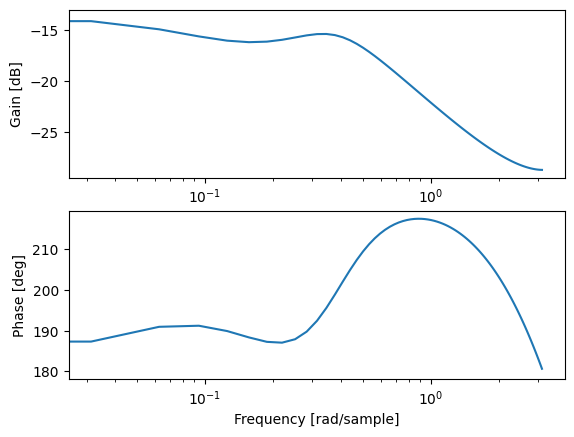

(array([0.        , 0.03141593, 0.06283185, 0.09424778, 0.12566371,
        0.15707963, 0.18849556, 0.21991149, 0.25132741, 0.28274334,
        0.31415927, 0.34557519, 0.37699112, 0.40840704, 0.43982297,
        0.4712389 , 0.50265482, 0.53407075, 0.56548668, 0.5969026 ,
        0.62831853, 0.65973446, 0.69115038, 0.72256631, 0.75398224,
        0.78539816, 0.81681409, 0.84823002, 0.87964594, 0.91106187,
        0.9424778 , 0.97389372, 1.00530965, 1.03672558, 1.0681415 ,
        1.09955743, 1.13097336, 1.16238928, 1.19380521, 1.22522113,
        1.25663706, 1.28805299, 1.31946891, 1.35088484, 1.38230077,
        1.41371669, 1.44513262, 1.47654855, 1.50796447, 1.5393804 ,
        1.57079633, 1.60221225, 1.63362818, 1.66504411, 1.69646003,
        1.72787596, 1.75929189, 1.79070781, 1.82212374, 1.85353967,
        1.88495559, 1.91637152, 1.94778745, 1.97920337, 2.0106193 ,
        2.04203522, 2.07345115, 2.10486708, 2.136283  , 2.16769893,
        2.19911486, 2.23053078, 2.26194671, 2.29

In [15]:
bode_rnn(network, output_weights, plot=True)

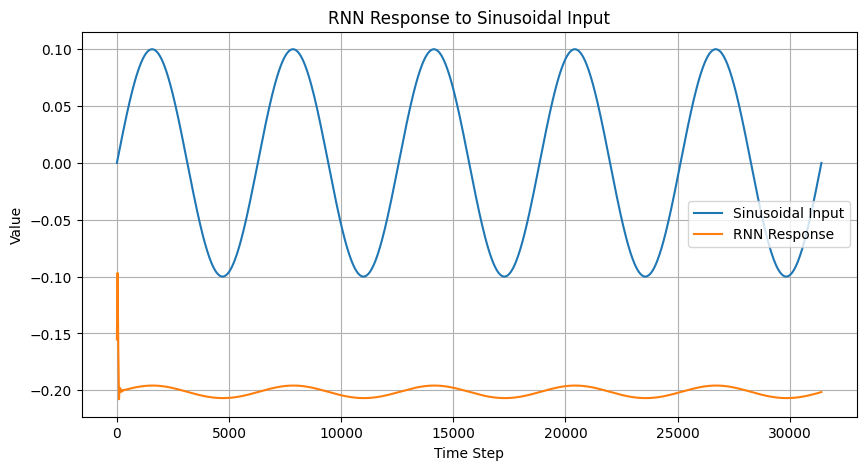

In [16]:
def sine_response(model, output_function=None, frequency=0.1, amplitude=1.0, time_steps=100, plot=False):
    # Generate a sinusoidal input signal
    t = np.linspace(0, 2 * np.pi * frequency * time_steps, time_steps)
    sinusoidal_input = torch.sin(torch.tensor(t)).view(1, time_steps, 1).float() # For some reason this was float64 before, float() converts it to 32
    sinusoidal_input = amplitude * sinusoidal_input  # Scale the signal by the amplitude

    # Feed the sinusoidal signal into the RNN
    output, _ = model(sinusoidal_input)
    
    if output_function is not None:
        output = output_function(output)

    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(t, sinusoidal_input[0, :, 0].numpy(), label='Sinusoidal Input')
        plt.plot(t, output[0, :, 0].detach().numpy(), label='RNN Response')
        plt.title('RNN Response to Sinusoidal Input')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.legend()
        plt.grid()
        plt.show()
    return sinusoidal_input, output

# Generate a sinusoidal input signal
time_steps = 1000
frequency = 5
amplitude = 0.1
input, response = sine_response(network, 
                                output_function=output_weights, 
                                frequency=frequency,
                                amplitude=amplitude,
                                time_steps=time_steps,
                                plot=True)

In [ ]:
def get_trajectory_length_expressivity(model, input_sequence, norm_order=2):
    """
    Computes the trajectory length of a deep network as described in
    "On the Expressive Power of Deep Neural Networks" (Raghu et al., 2017).
    Args:
        model: The neural network model (should output activations for each layer if possible).
        input_sequence: Input tensor of shape (batch, seq_len, input_dim) or (seq_len, input_dim).
        norm_order: Order of the norm to use for trajectory length (default: 2).
    Returns:
        traj_lengths: List of trajectory lengths for each layer.
    """
    # Helper to register hooks and collect activations
    activations = []

    def hook_fn(module, inp, out):
        # out shape: (batch, seq_len, features) or (seq_len, features)
        activations.append(out.detach().cpu())

    hooks = []
    # Register hooks for all layers except container modules
    for layer in model.modules():
        if isinstance(layer, (torch.nn.Linear, torch.nn.Conv2d, torch.nn.RNN, torch.nn.LSTM, torch.nn.GRU)):
            hooks.append(layer.register_forward_hook(hook_fn))

    # Forward pass
    with torch.no_grad():
        _ = model(input_sequence)

    # Remove hooks
    for h in hooks:
        h.remove()

    traj_lengths = []
    for act in activations:
        # Flatten batch and spatial dimensions if present
        if act.dim() > 2:
            act_flat = act.view(act.size(0), -1)
        else:
            act_flat = act
        # Compute trajectory length: sum of norms of differences between consecutive activations
        diffs = act_flat[1:] - act_flat[:-1]
        traj_length = torch.norm(diffs, p=norm_order, dim=1).sum().item()
        traj_lengths.append(traj_length)
    return traj_lengths

In [28]:
# Example usage
# Perform it on the RNN model
input_circle = [torch.sin(torch.tensor(t)).view(1, time_steps, 1).float() for t in np.linspace(0, 2 * np.pi * frequency * time_steps, time_steps)]
input_circle = torch.stack(input_circle, dim=0)  # Shape: (time_steps, 1, 1)

# Get the trajectory lengths
traj_lengths_rnn = get_trajectory_length_expressivity(network, input_circle, norm_order=2)
print("Trajectory lengths for RNN model:", traj_lengths_rnn)

# plot the trajectory lengths
plt.figure(figsize=(10, 5))
plt.plot(traj_lengths_rnn, label='RNN Trajectory Length')
plt.title('Trajectory Length of RNN Model')
plt.xlabel('Layer Index')
plt.ylabel('Trajectory Length')
plt.legend()
plt.grid()
plt.show()

RuntimeError: shape '[1, 1000, 1]' is invalid for input of size 1

MNIST dataset loaded successfully.
Sample indices: tensor([21379,  5381, 42540, 20174,  7961])


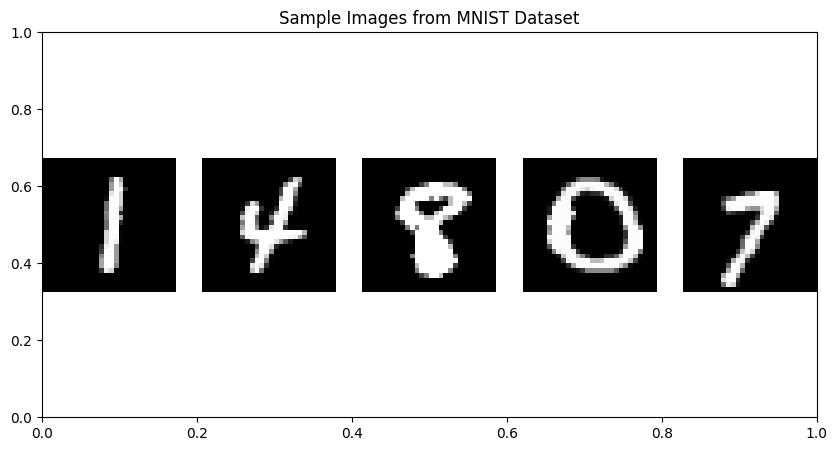

In [17]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

print("MNIST dataset loaded successfully.")

# Sample some images from the training and testing sets
sample_indices = torch.randint(0, len(train_dataset), (5,))
print("Sample indices:", sample_indices)
sample_images = [train_dataset[i][0] for i in sample_indices]
sample_labels = [train_dataset[i][1] for i in sample_indices]
fig = plt.figure(figsize=(10, 5))
plt.title("Sample Images from MNIST Dataset")

for i, image in enumerate(sample_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

In [18]:
# Create a simple RNN model for MNIST classification
# the Model consists of a simple CNN layer for feature extraction followed by an RNN layer 
# The RNN layer receives all of the features at once as a constant input.
# The classification is the interpretation of the RNN output after its output stabilizes (say, 10 time steps at first)
# The interpretation is done by a linear layer that maps the RNN output to the number of classes (10 for MNIST)
class StabilizingImageClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(StabilizingImageClassifier, self).__init__()
        self.conv = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=1)  # Convolutional layer
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
        # output size = 16 * 14 * 14 = 3584
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # Second convolutional layer
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Second max pooling layer
        # output size = 32 * 7 * 7 = 1568
        # Try to reduce the dimensionlaity of the feature maps as much as possible before the RNN layer
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Third convolutional layer
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Third max pooling layer
        # output size = 64 * 3 * 3 = 576

        self.flatten = nn.Flatten()  # Flatten layer to convert 2D feature maps to 1D
        
        self.rnn = nn.RNN(64 * 3 * 3, hidden_size, batch_first=True) # RNN layer
        self.fc = nn.Linear(hidden_size, num_classes)  # Fully connected layer for classification

    def forward(self, x, rollout=10):
        # x shape: (batch_size, channels, height, width)
        x = self.conv(x)  # Apply convolutional layer
        x = torch.relu(x)  # Activation function
        x = self.maxpool(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = torch.relu(x)
        x = self.maxpool3(x)
        x = self.flatten(x)

        # x shape: (batch_size, num_features)
        x = x.view(x.size(0), -1)  # Flatten the output for RNN input

        # Reshape for RNN input: (batch_size, seq_len, input_size)
        x = x.unsqueeze(1)  # Add sequence length dimension

        x = x.repeat(1, rollout, 1)  # Repeat the input for the specified rollout length
        # x shape: (batch_size, rollout, num_features)

        h_t_all, h_t_minus_1 = self.rnn(x)  # Apply RNN layer

        # Use the last output of the RNN for classification
        hidden_states = h_t_all
        out_all = self.fc(h_t_all)  # Get outputs at all time steps
        out_final = out_all[:, -1, :] # Get the output at the last time step
        return out_all, out_final, hidden_states # Return the output of the final rnn step, and the output of the rnn layer for all time steps


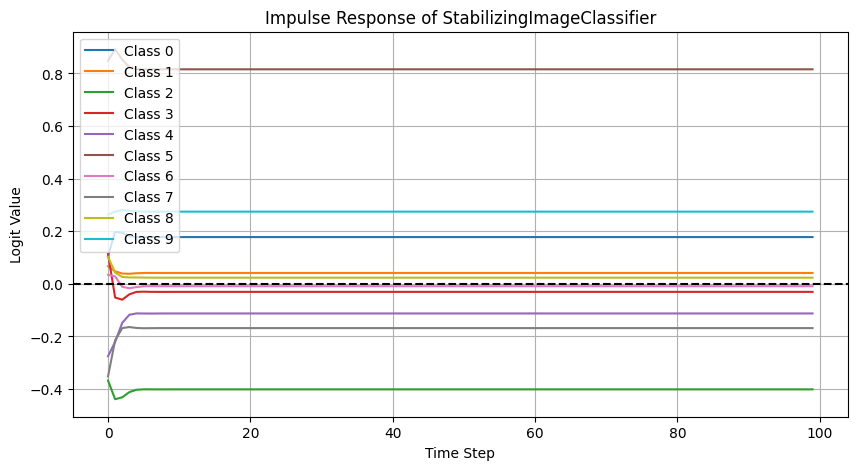

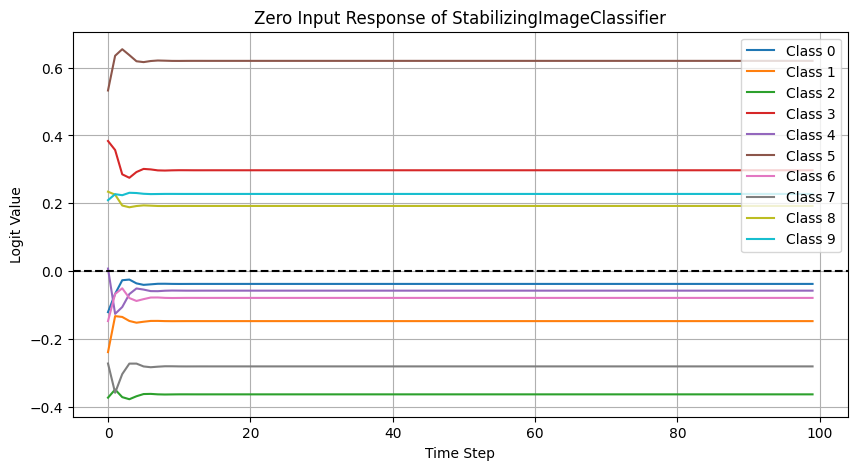

In [19]:
import random
# Create a function that runs an input through the classifier's CNN and maxpool layers once, 
# Passes it through the RNN's layers for n-rollouts, and then passes it through the output layer.
def run_through_classifier(model, input_image, rollout=10):
    # Pass the input image through the CNN and maxpool layers
    x = model.conv(input_image)  # Apply convolutional layer
    x = torch.relu(x)  # Activation function
    x = model.mnaxpool(x)  # Apply max pooling layer
    x = model.flatten(x)  # Flatten the output for RNN input

    # Reshape for RNN input: (batch_size, seq_len, input_size)
    x = x.view(x.size(0), -1)  # Flatten the output for RNN input
    x = x.unsqueeze(1)  # Add sequence length dimension

    x = x.repeat(1, rollout, 1)  # Repeat the input for the specified rollout length

    h_t_all, h_t_minus_1 = model.rnn(x)  # Apply RNN layer

    # Use the last output of the RNN for classification
    out = h_t_all[:, -1, :]  # Get the last time step output
    out = model.fc(out)  # Apply fully connected layer
    return out, model.fc(h_t_minus_1) # Return final prediction at end of rollout, plus the output of the RNN at each time step

# Create an impulse input, an image from the MNIST dataset
num_classes = 10
impulse_input = train_dataset[random.randint(0, len(train_dataset))][0].unsqueeze(0)  # Add batch dimension
# impulse_input = impulse_input.view(1, 1, 28, 28)  # Reshape to (batch_size, channels, height, width)
model = StabilizingImageClassifier(input_size=1, hidden_size=5, num_classes=10)  # Create the model
model.eval()

# Pass the impulse input through the network
rollout = 100  # Number of time steps to observe the response
all_out, final_out, hidden_states = model(impulse_input, rollout=rollout)  # Get the output of the RNN layer for all time steps

# Plot the output over time for each class
plt.figure(figsize=(10, 5))
for i in range(num_classes):
    plt.plot(all_out[0, :, i].detach().numpy(), label=f'Class {i}')
plt.axhline(y=0, color='k', linestyle='--')
plt.title('Impulse Response of StabilizingImageClassifier')
plt.xlabel('Time Step')
plt.ylabel('Logit Value')
plt.legend()
plt.grid()
plt.show()

# Now do it with a zero input to establish the baseline
zero_input = torch.zeros_like(impulse_input)  # Create a zero input
zero_input = zero_input.view(1, 1, 28, 28)  # Reshape to (batch_size, channels, height, width)

# Pass the zero input through the network
all_out, final_out, hidden_states = model(zero_input, rollout=rollout)  # Get the output of the RNN layer for all time steps

plt.figure(figsize=(10, 5))
for i in range(num_classes):
    plt.plot(all_out[0, :, i].detach().numpy(), label=f'Class {i}')
plt.axhline(y=0, color='k', linestyle='--')
plt.title('Zero Input Response of StabilizingImageClassifier')
plt.xlabel('Time Step')
plt.ylabel('Logit Value')
plt.legend()
plt.grid()
plt.show()

In [20]:
# train the neural network on the MNIST dataset
import torch.optim as optim
import torch.nn.functional as F
import time
# Define hyperparameters
input_size = 1  # Input size for the RNN (number of features per time step)
hidden_size = 5  # Number of hidden units in the RNN
num_classes = 10  # Number of output classes (digits 0-9)
num_epochs = 5  # Number of epochs to train
batch_size = 64  # Batch size for training
learning_rate = 0.001  # Learning rate for the optimizer

# Initialize the model, loss function, and optimizer
model = StabilizingImageClassifier(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()  # Loss function for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Optimizer

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    losses = []  # List to store losses for each batch
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        all_out, final_out, hidden_states = model(images)
        loss = criterion(final_out, labels)  # Compute the loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        losses.append(loss.item())
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")




Epoch [1/5], Loss: 0.9062
Epoch [2/5], Loss: 0.3716
Epoch [3/5], Loss: 0.2632
Epoch [4/5], Loss: 0.2173
Epoch [5/5], Loss: 0.1954


Accuracy of the model on the test set: 90.71%


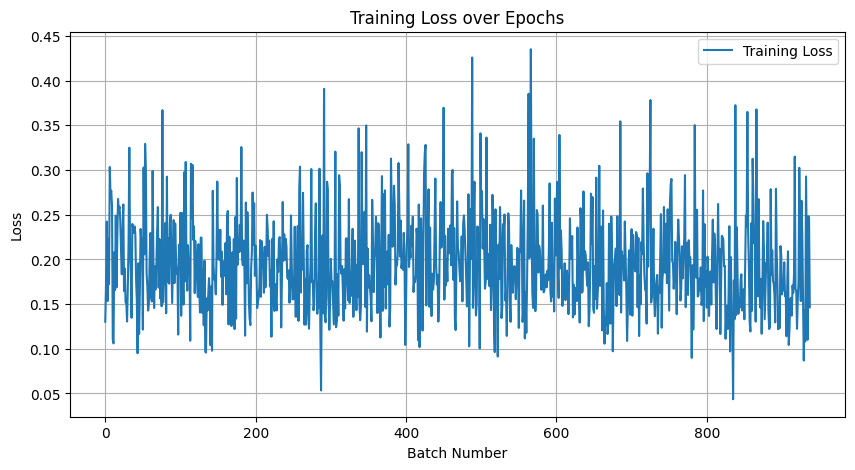

In [21]:
# Testing loop
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():  # Disable gradient calculation for testing
    for images, labels in test_loader:
        all_out, final_out, hidden_states = model(images)  # Forward pass
        _, predicted = torch.max(final_out, 1)  # Get the predicted class
        total += labels.size(0)  # Update total count
        correct += (predicted == labels).sum().item()  # Update correct count
accuracy = 100 * correct / total  # Calculate accuracy

print(f"Accuracy of the model on the test set: {accuracy:.2f}%")


plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

all_out.shape: torch.Size([1, 2, 10])


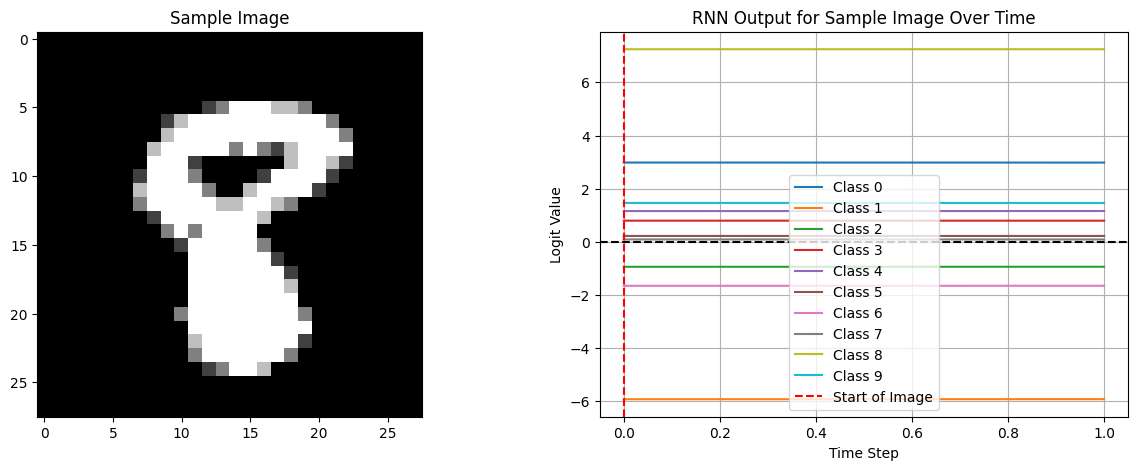

In [22]:
# Plot the output of the RNN for a sample image
# This is similar to the step response test, but we will use a sample image from the MNIST dataset, and keep the 
# Image as the input for the RNN for the entire 100 time steps.

sample_i = torch.randint(0, len(sample_images)-1, (1,))  # Randomly select an image index
sample_image = sample_images[sample_i].unsqueeze(0)  # Use the first sample image and add batch dimension



all_out, final_out, hidden_states = model(sample_image, rollout=2)  # Get the output of the RNN layer for all time steps

print("all_out.shape:", all_out.shape)  # Check the shape of the output

# rnn_out shape: (batch_size, seq_len, num_classes)
# Plot the output over time for each class
# show the image in the first subplot, and the output of the RNN in the second subplot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_image.squeeze(), cmap='gray')
plt.title("Sample Image")  

plt.subplot(1,2,2)
for i in range(num_classes):
    plt.plot(all_out[0, :, i].detach().numpy(), label=f'Class {i}')
plt.axhline(y=0, color='k', linestyle='--')
plt.axvline(x=0, color='r', linestyle='--', label='Start of Image')
plt.legend()
plt.title('RNN Output for Sample Image Over Time')
plt.xlabel('Time Step')
plt.ylabel('Logit Value')
plt.grid()
plt.show()



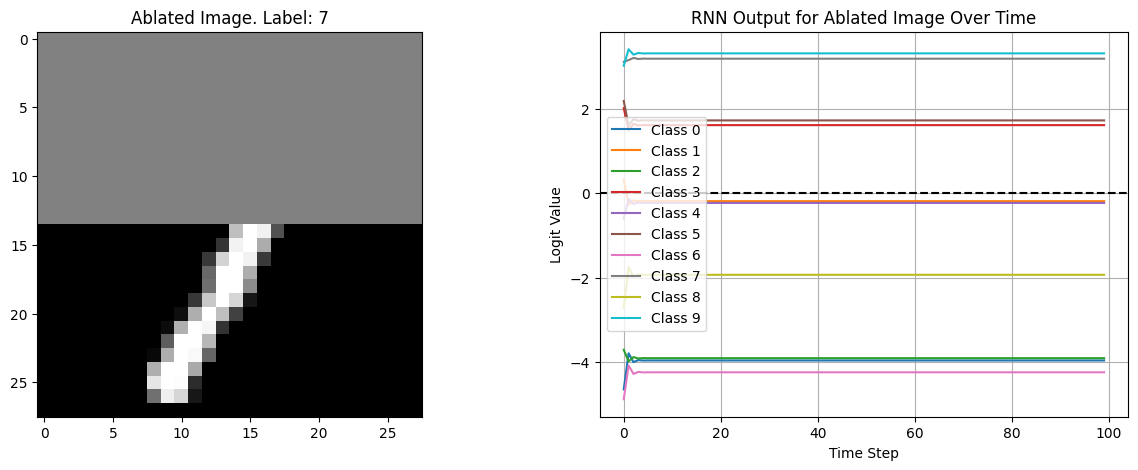

In [27]:
def ablate_image(image, mask):
    """
    Apply a mask to the input image to ablate certain regions.
    Args:
        image (torch.Tensor): Input image tensor of shape (1, 1, height, width).
        mask (torch.Tensor): Mask tensor of shape (height, width) with 1s for regions to keep and 0s for regions to ablate.
    Returns:
        torch.Tensor: Ablated image.
    """
    return image * mask.unsqueeze(0).unsqueeze(0)

# Create a mask to ablate part of the image (e.g., top half of the image)
height, width = sample_images[0].shape[1], sample_images[0].shape[2]
mask = torch.ones(height, width)
mask[:height // 2, :] = 0  # Set the top half of the mask to 0

# Select a random image from the sample_images
random_index = torch.randint(0, len(sample_images), (1,)).item()
random_image = sample_images[random_index].unsqueeze(0)  # Add batch dimension

# Apply the mask to ablate the image
ablated_image = ablate_image(random_image, mask)

# Pass the ablated image through the RNN for the entire rollout
rollout = 100  # Number of time steps to observe the response
all_out, final_out, hidden_states = model(ablated_image, rollout=rollout)

# Plot the ablated image and the RNN output over time
plt.figure(figsize=(15, 5))

# Plot the ablated image
plt.subplot(1, 2, 1)
plt.imshow(ablated_image.squeeze(), cmap='gray')
plt.title("Ablated Image. Label: " + str(sample_labels[random_index]))  # Show the label of the original image

# Plot the RNN output over time for each class
plt.subplot(1, 2, 2)
for i in range(num_classes):
    plt.plot(all_out[0, :, i].detach().numpy(), label=f'Class {i}')
plt.axhline(y=0, color='k', linestyle='--')
plt.title('RNN Output for Ablated Image Over Time')
plt.xlabel('Time Step')
plt.ylabel('Logit Value')
plt.legend()
plt.grid()
plt.show()

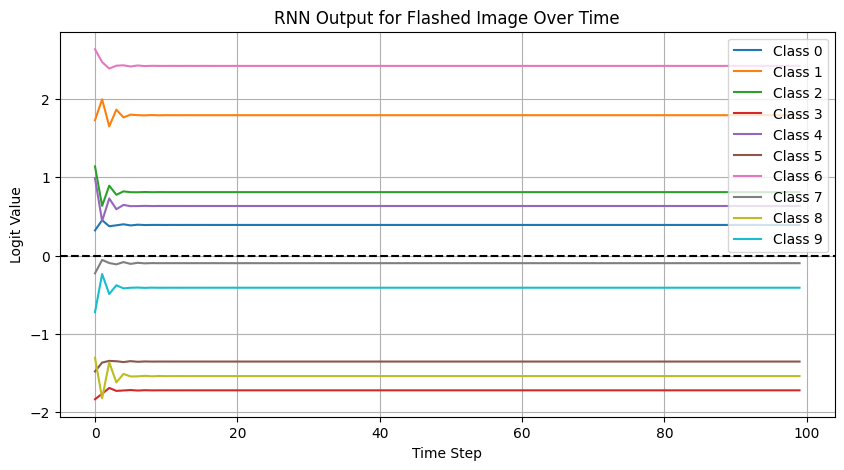

In [24]:
# Flash a random image from the MNIST dataset to the RNN, and observe the output over time
# This is similar to the step response test, but we will use a sample image from the MNIST dataset, and keep the   
# Image as the input for the RNN for just one time step.
# We need to create a special function that calls the CNN/maxpool layers of the image on each pulsed image, 
# and then passes the extracted features to the RNN as step impulses over one time step, at various times (say, every 10 time steps)

def extract_features(model, image):
    
    with torch.no_grad():
        x = model.conv(image)
        x = torch.relu(x)
        x = model.maxpool(x)
        x = model.conv2(x)
        x = torch.relu(x)
        x = model.maxpool2(x)
        x = model.conv3(x)
        x = torch.relu(x)
        x = model.maxpool3(x)
        x = model.flatten(x)
    return x  # Return the extracted features



def flash_images(model, images, pulse_length=1, response_time=10):
    # images shape: (batch_size, channels, height, width)
    # pulse_length: length of the pulse in time steps
    # response_time: time steps to observe the response

    # Get the number of images and their dimensions
    batch_size, channels, height, width = images.shape

    # Initialize the output tensor to store the RNN output over time
    rnn_output = torch.zeros(batch_size, response_time, model.fc.out_features)

    for t in range(response_time):
        if t % pulse_length == 0:
            # Create a pulse input by flashing the image at time step t
            pulse_input = images[:, :, :, :].clone()  # Clone the image tensor to create a pulse input
            pulse_input = pulse_input.view(batch_size, channels, height, width)  # Reshape to (batch_size, channels, height, width)
        else:
            # Create a zero input for other time steps
            pulse_input = torch.zeros_like(images)  # Create a zero input

        x = extract_features(model, pulse_input)

        # Reshape for RNN input: (batch_size, seq_len, input_size)
        x = x.view(x.size(0), -1)  # Flatten the output for RNN input
        x = x.unsqueeze(1)  # Add sequence length dimension

        x = x.repeat(1, response_time, 1)  # Repeat the input for the specified rollout length

        h_t_all, h_t_minus_1 = model.rnn(x)  # Apply RNN layer

        # Use the last output of the RNN for classification
        out_all = model.fc(h_t_all)       

    return out_all, h_t_all

# Select a random image from the sample_images
random_index = torch.randint(0, len(sample_images), (1,)).item()
random_image = sample_images[random_index].unsqueeze(0)  # Add batch dimension

# Flash the image to the RNN and observe the output
response_time = 100  # Number of time steps to observe the response
pulse_length = 10  # Length of the pulse in time steps
out_all, h_t_all = flash_images(model, random_image, pulse_length=pulse_length, response_time=response_time)

# Plot the output over time for each class
plt.figure(figsize=(10, 5))
for i in range(num_classes):
    plt.plot(out_all[0, :, i].detach().numpy(), label=f'Class {i}')
plt.axhline(y=0, color='k', linestyle='--')
plt.title('RNN Output for Flashed Image Over Time')
plt.xlabel('Time Step')
plt.ylabel('Logit Value')
plt.legend()
plt.grid()
plt.show()
